# TOPIC MODELING

Topic modeling can be defined as an approach to identifying a set of words (referred to as topics) within a corpus of documents that most accurately encapsulates the information contained within the collection. It can also be viewed as a type of text mining, enabling the extraction of recurring word patterns from textual data. In this project, we will employ unsupervised methodologies to cluster or group reviews, aiming to uncover primary themes or concepts embedded within the text. While this method can be applied to any textual data, we will concentrate on Twitter data due to its real-world relevance and the increased complexity it presents compared to reviews obtained from traditional review or survey formats.

## Import Libraries

In [64]:
import snscrape.modules.twitter as sntwitter # for tweet mining
import pandas as pd #for data cleaning
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt #for data visualization
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob #for text sentiment and processing word data
from wordcloud import WordCloud # for creating word visualization
from nltk.tokenize import word_tokenize # for word tokens
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
stop_words = set(stopwords.words('english'))
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import numpy as np
import re # remove regex
import pandas as pd 

## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Loading Dataset

In [5]:
# Load the CSV files into DataFrame objects
bank_transaction = pd.read_csv('bank_transaction.csv')
useless_bank = pd.read_csv('useless_bank.csv')
worst_bank = pd.read_csv('worst_bank.csv')

# Merge the DataFrames
merged_data = pd.concat([bank_transaction, useless_bank, worst_bank], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_data.to_csv('merged_tweets.csv', index=False)

# Optional: Display the first few rows of the merged DataFrame
print(merged_data.head())


             user                       date  \
0  GoibiboSupport  2022-12-27 11:31:56+00:00   
1      zomatocare  2022-12-27 11:31:27+00:00   
2    isoumyasinha  2022-12-27 11:30:42+00:00   
3      airtelbank  2022-12-27 11:28:26+00:00   
4      NotFroxity  2022-12-27 11:26:33+00:00   

                                               tweet  
0  @er_soumya Hi Soumya,\n\nWe already informed y...  
1  @Hemant27367066 transaction processing is TXN3...  
2  @TheOfficialSBI I made a UPI transaction on 09...  
3  @Sandeep61421534 Hi Sandeep! Please do not pro...  
4  The things I learned today is, isi minyak moto...  


In [7]:
# preview the Dataset
data = merged_data
pd.concat([data.head(),data.tail()])

user                       date  \
0       GoibiboSupport  2022-12-27 11:31:56+00:00   
1           zomatocare  2022-12-27 11:31:27+00:00   
2         isoumyasinha  2022-12-27 11:30:42+00:00   
3           airtelbank  2022-12-27 11:28:26+00:00   
4           NotFroxity  2022-12-27 11:26:33+00:00   
28587  RoshanJ04583183  2022-11-21 12:11:03+00:00   
28588  MichaelFarah961  2022-11-21 12:07:13+00:00   
28589      kushalchinu  2022-11-21 12:03:16+00:00   
28590        iambapu08  2022-11-21 11:57:23+00:00   
28591         TeuwsenT  2022-11-21 11:55:39+00:00   

                                                   tweet  
0      @er_soumya Hi Soumya,\n\nWe already informed y...  
1      @Hemant27367066 transaction processing is TXN3...  
2      @TheOfficialSBI I made a UPI transaction on 09...  
3      @Sandeep61421534 Hi Sandeep! Please do not pro...  
4      The things I learned today is, isi minyak moto...  
28587  @KotakBankLtd Worst bank koi reply nhi msg ka ...  
28588  @CapitecBankSA is the worst bank I've ever ban...  
28589  @KotakCares each and every day I am visiting t...  
28590  @AxisBankSupport Worst service at  axis bank k...  
28591  Nederlanders het boek\n" Worst Bank Scenario "...

In [8]:
# shape of Dataset
data.shape

(28592, 3)

## Data Cleaning

In [10]:
# info on Dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28592 entries, 0 to 28591
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    28592 non-null  object
 1   date    28592 non-null  object
 2   tweet   28592 non-null  object
dtypes: object(3)
memory usage: 670.2+ KB


In [14]:
# checking for Null values 
null_values = data.isnull().any()
null_values

user     False
date     False
tweet    False
dtype: bool

I'll concentrate on the textual data since it is pivotal to the analysis

In [20]:
#extracting the tweet data
tweet_data = data[["tweet"]]
pd.concat([tweet_data.head(),tweet_data.tail()])

tweet
0      @er_soumya Hi Soumya,\n\nWe already informed y...
1      @Hemant27367066 transaction processing is TXN3...
2      @TheOfficialSBI I made a UPI transaction on 09...
3      @Sandeep61421534 Hi Sandeep! Please do not pro...
4      The things I learned today is, isi minyak moto...
28587  @KotakBankLtd Worst bank koi reply nhi msg ka ...
28588  @CapitecBankSA is the worst bank I've ever ban...
28589  @KotakCares each and every day I am visiting t...
28590  @AxisBankSupport Worst service at  axis bank k...
28591  Nederlanders het boek\n" Worst Bank Scenario "...

Next i'll  remove unwanted character/symbols and drop duplicates.

In [33]:
# function for removing unwanted charaters from tweets
def data_processing(tweet):
    tweet= tweet.lower() #change all words to lowercase
    tweet = re.sub(r'https\S+|www\S+https\S+', '', tweet, flags=re.MULTILINE) #remove links/url
    tweet = re.sub(r'@w+|\#','',tweet) #remove hashtags and special symbols
    tweet = re.sub(r'[^\w\s]','',tweet)
    #remove stop words
    tweet_tokens = word_tokenize(tweet) #convert strings to tokens
    filtered_text = [w for w in tweet_tokens if not w in stop_words]
    return ' '.join(filtered_text)

In [34]:
# applying function
import warnings 
warnings.filterwarnings('ignore')#I use this pip to remove warning messages
tweet_data['clean_tweet'] = tweet_data['tweet'].apply(data_processing) #apply data preprocess tweets
pd.concat([tweet_data.head(),tweet_data.tail()])

tweet  \
0      @er_soumya Hi Soumya,\n\nWe already informed y...   
1      @Hemant27367066 transaction processing is TXN3...   
2      @TheOfficialSBI I made a UPI transaction on 09...   
3      @Sandeep61421534 Hi Sandeep! Please do not pro...   
4      The things I learned today is, isi minyak moto...   
28587  @KotakBankLtd Worst bank koi reply nhi msg ka ...   
28588  @CapitecBankSA is the worst bank I've ever ban...   
28589  @KotakCares each and every day I am visiting t...   
28590  @AxisBankSupport Worst service at  axis bank k...   
28591  Nederlanders het boek\n" Worst Bank Scenario "...   

                                             clean_tweet  
0      er_soumya hi soumya already informed rare inst...  
1      hemant27367066 transaction processing txn30284...  
2      theofficialsbi made upi transaction 09 decembe...  
3      sandeep61421534 hi sandeep please provide acco...  
4      things learned today isi minyak motor pakai de...  
28587  kotakbankltd worst bank koi reply nhi msg ka b...  
28588  capitecbanksa worst bank ive ever banked absol...  
28589  kotakcares every day visiting bank reply getti...  
28590  axisbanksupport worst service axis bank khadat...  
28591  nederlanders het boek worst bank scenario van ...

Next I'll drop Duplicates to eradicate the issue of repetitive tweets

In [36]:
# drop duplicates 
tweet_data = tweet_data.drop_duplicates('clean_tweet')
# print data set
pd.concat([tweet_data.head(),tweet_data.tail()])

tweet  \
0      @er_soumya Hi Soumya,\n\nWe already informed y...   
1      @Hemant27367066 transaction processing is TXN3...   
2      @TheOfficialSBI I made a UPI transaction on 09...   
3      @Sandeep61421534 Hi Sandeep! Please do not pro...   
4      The things I learned today is, isi minyak moto...   
28587  @KotakBankLtd Worst bank koi reply nhi msg ka ...   
28588  @CapitecBankSA is the worst bank I've ever ban...   
28589  @KotakCares each and every day I am visiting t...   
28590  @AxisBankSupport Worst service at  axis bank k...   
28591  Nederlanders het boek\n" Worst Bank Scenario "...   

                                             clean_tweet  
0      er_soumya hi soumya already informed rare inst...  
1      hemant27367066 transaction processing txn30284...  
2      theofficialsbi made upi transaction 09 decembe...  
3      sandeep61421534 hi sandeep please provide acco...  
4      things learned today isi minyak motor pakai de...  
28587  kotakbankltd worst bank koi reply nhi msg ka b...  
28588  capitecbanksa worst bank ive ever banked absol...  
28589  kotakcares every day visiting bank reply getti...  
28590  axisbanksupport worst service axis bank khadat...  
28591  nederlanders het boek worst bank scenario van ...

Next I'll create a list of the names of all the banks in Nigeria with popular mentions.

In [37]:
# Full list of Mst bank anmes in this trend, to avoid name repetitions/duplicates I used bank names and abbr

bank_list = ['zenith', 'zenithbank', 'gtb', 'gtbank', 'kuda','kudabank', 'eco', 'ecobank', 'access','first bank',  
             'jaiz', 'polaris', 'wema', 'alat', 'ubagroup','uba', 'sterling', 'fidelity', 'vbank',
            'unionbank', 'unitybank', 'fcmb', 'stanchart', 'palmpay', 'keystone']  

In [39]:
# create a function to extract bank names
def getBankNames(tweet):
    tweet = tweet.lower() #to create uniformity, I lowered the cases
    tweet_tokens = word_tokenize(tweet) #to split words
    bank_names = [bank for bank in tweet_tokens if bank in bank_list] #to extract bank names
    return " ".join(bank_names)

In [40]:
# apply the function and create a new column
tweet_data['bank_names'] = tweet_data['tweet'].apply(getBankNames) 

In [43]:
 #view the effect of the code
tweet_data.loc[(tweet_data['bank_names'] == 'zenith')].head(10) 


tweet  \
32    @Zenithbank_87 \n\nThese are fraudulent people...   
327   Despite Not Initiating a Transaction, Zenith B...   
368   We should be glad the Pharisees didn’t use Zen...   
501   @FBN_help 3058497381\nEtor Alice ukureveh - fi...   
509   Zenith Bank have started....\nYou can log in t...   
604   Has anyone done transaction through their phon...   
794   Zenith bank nice one! Denied me major transact...   
938   @Naija_PR The transaction for still dey write ...   
1138  Finallyyyy, I've been able to sort a transacti...   
1163  The way Zenith bank frustrated my transaction ...   

                                            clean_tweet bank_names  
32    zenithbank_87 fraudulent people zenith bank ca...     zenith  
327   despite initiating transaction zenith bank cus...     zenith  
368   glad pharisees didnt use zenith bank send juda...     zenith  
501   fbn_help 3058497381 etor alice ukureveh first ...     zenith  
509       zenith bank started log app quick transaction     zenith  
604   anyone done transaction phone zenith bank morning     zenith  
794   zenith bank nice one denied major transaction ...     zenith  
938   naija_pr transaction still dey write processin...     zenith  
1138  finallyyyy ive able sort transaction zenith ba...     zenith  
1163  way zenith bank frustrated transaction today a...     zenith

Next ill make names of banks consistent by replacing it with a particular name .

In [50]:
# create the function
def correct_bank_names(bank_names):
    replacements = [('zenithbank', 'zenith'), ('gtbank', 'gtb'), ('kudabank', 'kuda'), ('ecobank', 'eco'),
                  ('accessbank', 'access'), ('first bank', 'firstbank'), ('ubagroup', 'uba'), ('wemabank', 'wema')]
    for pat, repl in replacements:
        bank_names= re.sub(pat, repl, bank_names)
    return bank_names

In [51]:
# testing the function
tweet_test = 'this ecobank can most times influence kudabank zenithbank to  go to gtbank and accessbank to benefit first bank wemabank'
correct_bank_names(tweet_test)

'this eco can most times influence kuda zenith to  go to gtb and access to benefit firstbank wema'

In [52]:
#Applying the functions
tweet_data['bank_names'] = tweet_data['bank_names'].apply(correct_bank_names) 

In [53]:
# Extract bank names from the 'bank_names' column and convert to list
bank_listing = tweet_data['bank_names'].tolist()

# Initialize an empty list to store individual bank names
banks = []

# Iterate over each item in bank_listing
for item in bank_listing:
    # Split the item into individual words
    item = item.split()
    # Iterate over each word in the item
    for i in item:
        # Append the word to the list of banks
        banks.append(i)


In [55]:
# Count occurrences of each bank name
counts = Counter(banks)

# Convert the counts dictionary to a DataFrame
bank_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()

# Rename the columns
bank_df.columns = ['Banks', 'Count']

# Sort the DataFrame by count in descending order
bank_df.sort_values(by='Count', ascending=False, inplace=True)

# Print the total number of unique banks
print(f'Total Number of Unique Banks: {bank_df.shape[0]}')

# Display the top 20 banks with the highest counts
bank_df.head(20)


Total Number of Unique Banks: 18


Banks  Count
1      zenith   2714
8         gtb    960
5      access    912
3         uba    850
2        kuda    306
10   fidelity    181
9    sterling    148
0        wema    114
12    polaris     82
14       fcmb     82
6         eco     71
11   keystone     68
7   stanchart     67
4     palmpay     41
13  unionbank     17
15       alat     14
16      vbank      2
17       jaiz      2

### Vectorization

Vectorization refers to the process of converting data into a numerical format that can be processed by machine learning algorithms efficiently. This often involves representing data as vectors or matrices, where each element in the vector or matrix corresponds to a feature or attribute of the data.

**TfidfVectorizer**:

Convert a collection of raw documents to a matrix of TF-IDF features.
In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

**CountVectorizer**:

Convert a collection of text documents to a matrix of token counts
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary\
Number of features will be equal to the vocabulary size found by analyzing the data.


In [59]:
# Initializing CountVectorizer with specified parameters
count_vect = CountVectorizer(
    analyzer='word',        # Specify that words will be used as features
    ngram_range=(1, 1),     # Use unigrams (single words) only
    stop_words='english',   # Remove English stopwords
    min_df=0.0001,          # Ignore terms that have a document frequency strictly lower than the given threshold
    max_df=0.7              # Ignore terms that have a document frequency strictly higher than the given threshold
)

# Fitting CountVectorizer to the cleaned text data
count_vect.fit(tweet_data['clean_tweet'])

# Transforming the cleaned text data into a document-term matrix
desc_matrix = count_vect.transform(tweet_data["clean_tweet"])

desc_matrix

CountVectorizer(max_df=0.7, min_df=0.0001, stop_words='english')

<27128x10940 sparse matrix of type '<class 'numpy.int64'>'
	with 354238 stored elements in Compressed Sparse Row format>

In [60]:
# Converting the sparse matrix to a dense array representation
desc_matrix_dense = desc_matrix.toarray()

# Printing the dense array representation
print(desc_matrix_dense)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [61]:
desc_matrix_dense.shape

(27128, 10940)

## Clustering

In [65]:
# Specify the number of clusters
num_clusters = 2

# Initialize KMeans model with the specified number of clusters
km = KMeans(n_clusters=num_clusters)

# Fit the KMeans model to the document-term matrix
km.fit(desc_matrix)

# Assign each document to a cluster and convert the labels to a list
clusters = km.labels_.tolist()


KMeans(n_clusters=2)

In [68]:
# Create a dictionary containing tweets and their assigned clusters
tweets = {'Tweet': tweet_data["clean_tweet"].tolist(), 'Cluster': clusters}

# Create a DataFrame from the dictionary with cluster indices as index
frame = pd.DataFrame(tweets, index=[clusters])

# Concatenate the first and last 20 rows of the DataFrame for display
pd.concat([frame.head(20), frame.tail(20)])


Tweet  Cluster
0  er_soumya hi soumya already informed rare inst...        0
0  hemant27367066 transaction processing txn30284...        0
0  theofficialsbi made upi transaction 09 decembe...        0
1  sandeep61421534 hi sandeep please provide acco...        1
0  things learned today isi minyak motor pakai de...        0
0  desaihimaja sorry hear withdrawals take upto 3...        0
0  avi_monu10 unauthorisedtransactionsbicoin call...        0
0  avi_monu10 order assist effectively kindly ela...        0
1  kotakbankltd yet receive credit card fraud txn...        1
0  cteeblack olamiotan_1 convertedcode_1 ekitipik...        0
0  please check revert well wise quit bank 1st tr...        0
0  kotakbankltd facebook bank account kotak mahin...        0
0  spyder_verse understand concern please registe...        0
0  cimb_assists transaction bank dah succesful ta...        0
0  vinayver0199 regret inconvenience caused per c...        0
0  narendrayadavvv please note complaint closed f...        0
0  alirazasuterwal transaction download app part ...        0
0  keequitybank transaction charge transferring m...        0
0  mtnng hello mtnng made transaction mtn app yes...        0
0  icked_sny never ask initiate financial transac...        0
1  makemytripcare worst experience received order...        1
1              worst jumpscare checking bank account        1
1  black friday sales probably worst time buy apa...        1
1  waiting bank reply weekend messages worst left...        1
1  theofficialsbi sbilife one worst bank india al...        1
1  mondays worst pending transactions weekend cle...        1
1  hdfc_bank worst bank customerservice infinity ...        1
1  bristolfingers tell us really think jon though...        1
1  yall love talk pennywise workers attitudes ban...        1
1  diveymehta sbicard_connect worst service exper...        1
1  icicibank reminder youre worst bank take 7 day...        1
1  worst bank terms cash deposit service sbi faci...        1
1  never expected icicibank gives worst services ...        1
1       theofficialsbi worst bank terms upi services        1
1                                     pnc worst bank        1
1  kotakbankltd worst bank koi reply nhi msg ka b...        1
1  capitecbanksa worst bank ive ever banked absol...        1
1  kotakcares every day visiting bank reply getti...        1
1  axisbanksupport worst service axis bank khadat...        1
1  nederlanders het boek worst bank scenario van ...        1

In [70]:
# Count the frequency of each cluster label in the 'Cluster' column
# of the DataFrame `frame` and store the result in a Series.
cluster_counts = frame['Cluster'].value_counts()
cluster_counts

1    17578
0     9550
Name: Cluster, dtype: int64

In [71]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 0,
# indicating tweets belonging to cluster 0, and store the result in `cluster_0`.
cluster_0 = frame[frame['Cluster'] == 0]
cluster_0.head(10)

Tweet  Cluster
0  er_soumya hi soumya already informed rare inst...        0
0  hemant27367066 transaction processing txn30284...        0
0  theofficialsbi made upi transaction 09 decembe...        0
0  things learned today isi minyak motor pakai de...        0
0  desaihimaja sorry hear withdrawals take upto 3...        0
0  avi_monu10 unauthorisedtransactionsbicoin call...        0
0  avi_monu10 order assist effectively kindly ela...        0
0  cteeblack olamiotan_1 convertedcode_1 ekitipik...        0
0  please check revert well wise quit bank 1st tr...        0
0  kotakbankltd facebook bank account kotak mahin...        0

Next I'll Visualize the cluster

In [75]:
def wordcloud(cluster):
    # Now I'll use the WordCloud function from the wordcloud library 
    wc = WordCloud(background_color='white', height=1500, width=4000).generate(cluster)

    # Size of the image generated 
    plt.figure(figsize=(10,20))

    # Plot the word cloud
    plt.imshow(wc, interpolation="hamming")
    plt.axis('off')
    plt.show()




In [76]:
# Join all the tweets in cluster_0 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_0_words`.
cluster_0_words = ' '.join(text for text in cluster_0['Tweet'])


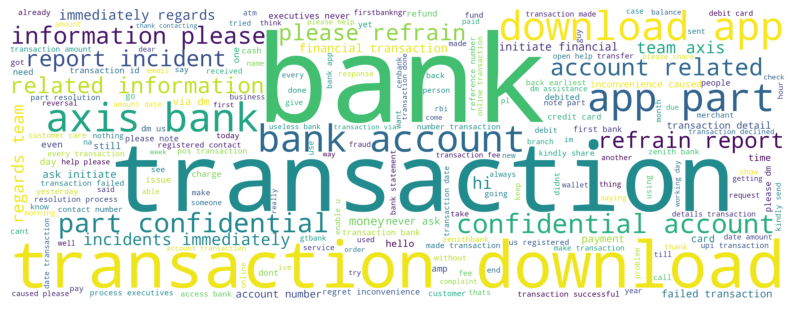

In [77]:
#  call the function to show word cloud 
wordcloud(cluster_0_words)



In [78]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 1,
# indicating tweets belonging to cluster 0, and store the result in `cluster_1`.
cluster_1=frame[frame['Cluster'] == 1]
cluster_1.head(10)

Tweet  Cluster
1  sandeep61421534 hi sandeep please provide acco...        1
1  kotakbankltd yet receive credit card fraud txn...        1
1  brajesh79016339 thank reaching us please login...        1
1  paytm worst customer care service 3 months im ...        1
1  heritagebankplc worst bank nigeria taking 4 da...        1
1  drm_lko rudauli1 railminindia gm_nrly ir_crb s...        1
1  frm mentee farmer took time never gave upnow c...        1
1  raised dispute regarding transactionfilpkart s...        1
1  heritagebankplc hbcustomercare yet credit tran...        1
1  sumitkm16 regret inconvenience caused please r...        1

In [79]:
# Join all the tweets in cluster_1 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_0_words`.
cluster_1_words = ' '.join(text for text in cluster_1['Tweet'])

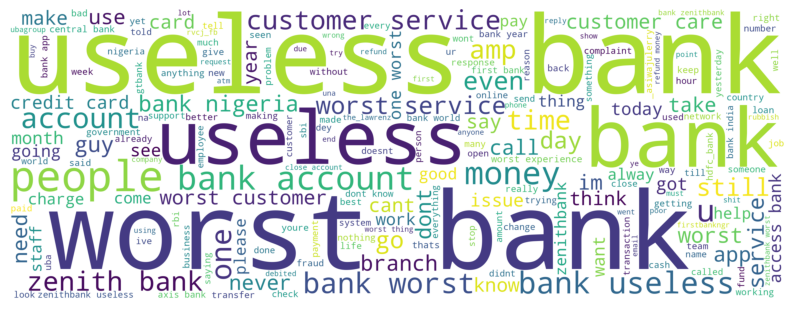

In [80]:
#  call the function to show word cloud 
wordcloud(cluster_1_words)

The topics in one of the clusters is all over the place. I'll create a more detailed clusters

In [81]:
# Set the number of clusters
num_clusters = 5

# Initialize the KMeans algorithm with the specified number of clusters
km = KMeans(n_clusters=num_clusters)

# Fit the KMeans model to the data
km.fit(desc_matrix)

# Assign each data point to a cluster and convert the cluster assignments to a list
clusters = km.labels_.tolist()


KMeans(n_clusters=5)

In [82]:
# Create a dictionary containing tweets and their assigned clusters
tweets = {'Tweet': tweet_data["clean_tweet"].tolist(), 'Cluster': clusters}

# Create a DataFrame from the dictionary with cluster indices as index
frame = pd.DataFrame(tweets, index=[clusters])

# Concatenate the first and last 20 rows of the DataFrame for display
pd.concat([frame.head(20), frame.tail(20)])

Tweet  Cluster
3  er_soumya hi soumya already informed rare inst...        3
3  hemant27367066 transaction processing txn30284...        3
2  theofficialsbi made upi transaction 09 decembe...        2
3  sandeep61421534 hi sandeep please provide acco...        3
3  things learned today isi minyak motor pakai de...        3
3  desaihimaja sorry hear withdrawals take upto 3...        3
3  avi_monu10 unauthorisedtransactionsbicoin call...        3
3  avi_monu10 order assist effectively kindly ela...        3
0  kotakbankltd yet receive credit card fraud txn...        0
3  cteeblack olamiotan_1 convertedcode_1 ekitipik...        3
3  please check revert well wise quit bank 1st tr...        3
3  kotakbankltd facebook bank account kotak mahin...        3
3  spyder_verse understand concern please registe...        3
3  cimb_assists transaction bank dah succesful ta...        3
3  vinayver0199 regret inconvenience caused per c...        3
3  narendrayadavvv please note complaint closed f...        3
1  alirazasuterwal transaction download app part ...        1
2  keequitybank transaction charge transferring m...        2
3  mtnng hello mtnng made transaction mtn app yes...        3
1  icked_sny never ask initiate financial transac...        1
0  makemytripcare worst experience received order...        0
0              worst jumpscare checking bank account        0
2  black friday sales probably worst time buy apa...        2
0  waiting bank reply weekend messages worst left...        0
0  theofficialsbi sbilife one worst bank india al...        0
0  mondays worst pending transactions weekend cle...        0
0  hdfc_bank worst bank customerservice infinity ...        0
0  bristolfingers tell us really think jon though...        0
0  yall love talk pennywise workers attitudes ban...        0
0  diveymehta sbicard_connect worst service exper...        0
0  icicibank reminder youre worst bank take 7 day...        0
0  worst bank terms cash deposit service sbi faci...        0
0  never expected icicibank gives worst services ...        0
0       theofficialsbi worst bank terms upi services        0
0                                     pnc worst bank        0
0  kotakbankltd worst bank koi reply nhi msg ka b...        0
0  capitecbanksa worst bank ive ever banked absol...        0
0  kotakcares every day visiting bank reply getti...        0
0  axisbanksupport worst service axis bank khadat...        0
0  nederlanders het boek worst bank scenario van ...        0

In [83]:
# Count the frequency of each cluster label in the 'Cluster' column
# of the DataFrame `frame` and store the result in a Series.
cluster_counts = frame['Cluster'].value_counts()
cluster_counts

0    9156
4    7829
3    7194
2    2029
1     920
Name: Cluster, dtype: int64

In [84]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 0,
# indicating tweets belonging to cluster 0, and store the result in `cluster_0`.
cluster_0 = frame[frame['Cluster'] == 0]
cluster_0.head(10)

Tweet  Cluster
0  kotakbankltd yet receive credit card fraud txn...        0
0  paytm worst customer care service 3 months im ...        0
0  heritagebankplc worst bank nigeria taking 4 da...        0
0  raised dispute regarding transactionfilpkart s...        0
0  heritagebankplc hbcustomercare yet credit tran...        0
0  sumitkm16 regret inconvenience caused please r...        0
0  korean bank transfer proxy service open 1000 k...        0
0  alat_ng worst bank bank know worst customer ca...        0
0  hardik18032 bankofbarodaceo rbi would like inf...        0
0  ghansyamkhatve transactionsgtgtupi unauthorize...        0

In [85]:
# Join all the tweets in cluster_0 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_0_words`.
cluster_0_words = ' '.join(text for text in cluster_0['Tweet'])


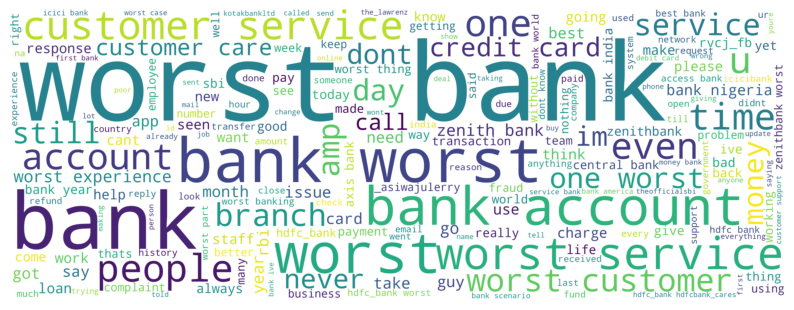

In [86]:
#  call the function to show word cloud 
wordcloud(cluster_0_words)

Tweet  Cluster
1  alirazasuterwal transaction download app part ...        1
1  icked_sny never ask initiate financial transac...        1
1  agarvikas executives never ask initiate financ...        1
1  musadiqueahmed4 transaction download app part ...        1
1  kediaankit777 transaction download app part co...        1
1  inclinedstudio initiate financial transaction ...        1
1  losvegas01 transaction download app part confi...        1
1  omkar_joshi_9 transaction download app part co...        1
1  abhishe69661807 initiate financial transaction...        1
1  erlokendradhan1 initiate financial transaction...        1

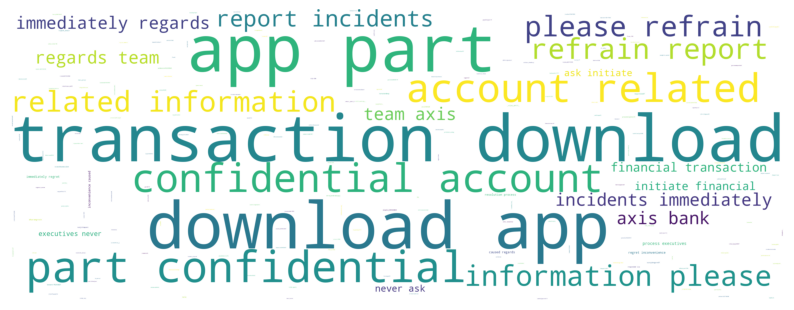

In [88]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 1,
# indicating tweets belonging to cluster 1, and store the result in `cluster_1`.
cluster_1 = frame[frame['Cluster'] == 1]
cluster_1.head(10)

# Join all the tweets in cluster_0 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_0_words`.
cluster_1_words = ' '.join(text for text in cluster_1['Tweet'])

#  call the function to show word cloud 
wordcloud(cluster_1_words)

Tweet  Cluster
2  theofficialsbi made upi transaction 09 decembe...        2
2  keequitybank transaction charge transferring m...        2
2  daily transaction limit see bank app n10000000...        2
2  zenithbank whats happening bank guys reverse m...        2
2  _bankislam hello bank islam would like make co...        2
2  sent money zenith bank palmpay transaction was...        2
2  emabank would like know status transaction 15t...        2
2  bank ghana raises mobile money transaction lim...        2
2  palmpay_ng tried make pos withdrawal one merch...        2
2  unionbank_ng yesterday went two different pos ...        2

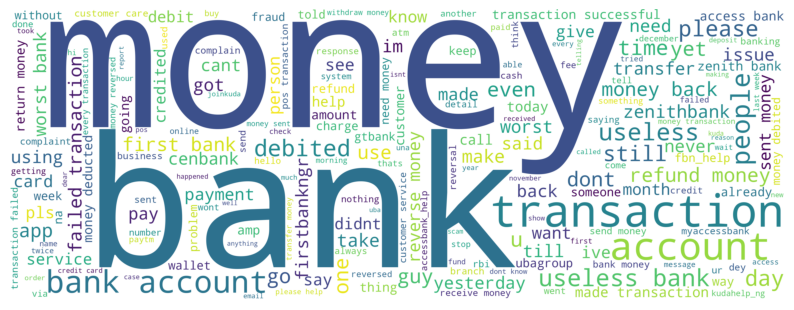

In [89]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 2,
# indicating tweets belonging to cluster 2, and store the result in `cluster_2`.
cluster_2 = frame[frame['Cluster'] == 2]
cluster_2.head(10)

# Join all the tweets in cluster_0 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_2_words`.
cluster_2_words = ' '.join(text for text in cluster_2['Tweet'])

#  call the function to show word cloud 
wordcloud(cluster_2_words)

Tweet  Cluster
3  er_soumya hi soumya already informed rare inst...        3
3  hemant27367066 transaction processing txn30284...        3
3  sandeep61421534 hi sandeep please provide acco...        3
3  things learned today isi minyak motor pakai de...        3
3  desaihimaja sorry hear withdrawals take upto 3...        3
3  avi_monu10 unauthorisedtransactionsbicoin call...        3
3  avi_monu10 order assist effectively kindly ela...        3
3  cteeblack olamiotan_1 convertedcode_1 ekitipik...        3
3  please check revert well wise quit bank 1st tr...        3
3  kotakbankltd facebook bank account kotak mahin...        3

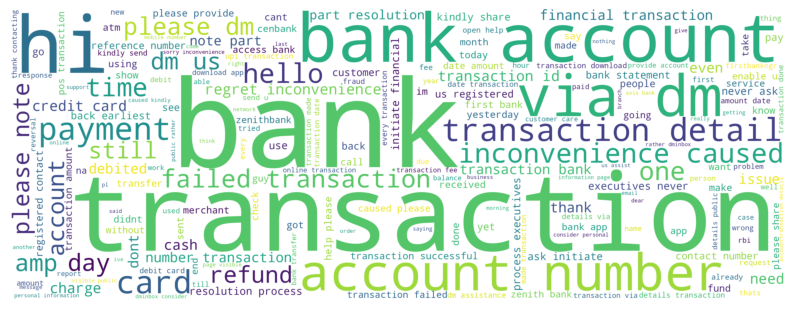

In [90]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 3,
# indicating tweets belonging to cluster 1, and store the result in `cluster_3`.
cluster_3 = frame[frame['Cluster'] == 3]
cluster_3.head(10)

# Join all the tweets in cluster_0 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_0_words`.
cluster_3_words = ' '.join(text for text in cluster_3['Tweet'])

#  call the function to show word cloud 
wordcloud(cluster_3_words)

Tweet  Cluster
4  drm_lko rudauli1 railminindia gm_nrly ir_crb s...        4
4  frm mentee farmer took time never gave upnow c...        4
4  mixtapeyourlife noliewithbtc would go terms 10...        4
4  firstbankngr fbnis useless bank made many nige...        4
4  frm menteethis farmer took time never gave upn...        4
4  drm_lko rudauli1 railminindia gm_nrly ir_crb s...        4
4  rbi update complaint n202223005010932 bank kee...        4
4  travancore state bank employees association ex...        4
4  lindaajayi3 davidhundeyin zenithbank instead i...        4
4  drm_lko rudauli1 railminindia gm_nrly ir_crb s...        4

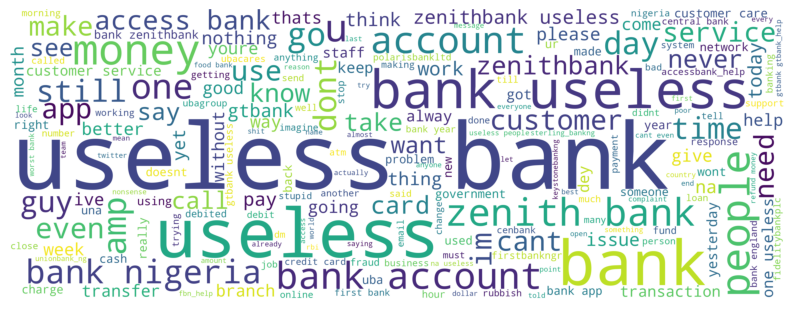

In [91]:
# Filter the DataFrame `frame` to include only rows where the 'Cluster' column equals 4,
# indicating tweets belonging to cluster 1, and store the result in `cluster_4`.
cluster_4 = frame[frame['Cluster'] == 4 ]
cluster_4.head(10)

# Join all the tweets in cluster_0 into a single string, separating each tweet by a space,
# and store the result in the variable `cluster_0_words`.
cluster_4_words = ' '.join(text for text in cluster_4['Tweet'])

#  call the function to show word cloud 
wordcloud(cluster_4_words)

Next I'LL create a function that will take in the number of clusters and visulaize the topics in world cloud so i can pick the best number of clusters 

In [92]:
def identify_topics(df, desc_matrix, num_clusters):
    km = KMeans(n_clusters=num_clusters)
    km.fit(desc_matrix)
    clusters = km.labels_.tolist()
    tweets = {'Tweet': tweet_data["clean_tweet"].tolist(), 'Cluster': clusters}
    frame = pd.DataFrame(tweets, index = [clusters])
    print(frame['Cluster'].value_counts())

    
    for cluster in range(num_clusters):
        cluster_words = ' '.join(text for text in frame[frame['Cluster'] == cluster]['Tweet'])
        wordcloud(cluster_words)

I'll apply the function for more clusters and see it topic modelling

**application on 7 clusters** 

3    7451
6    7388
2    6509
1    1941
5    1930
4     989
0     920
Name: Cluster, dtype: int64


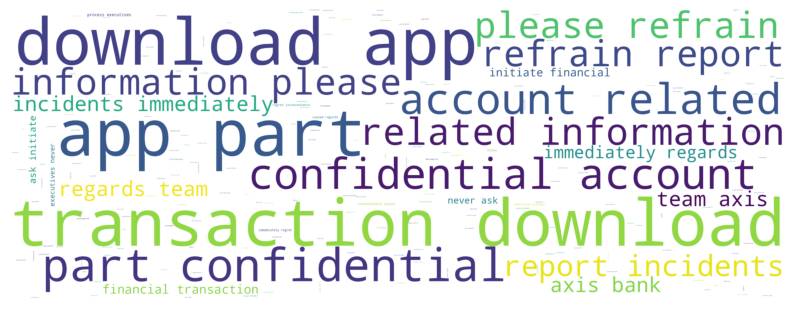

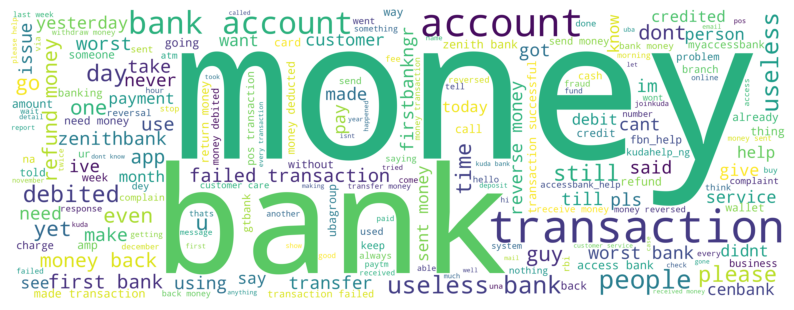

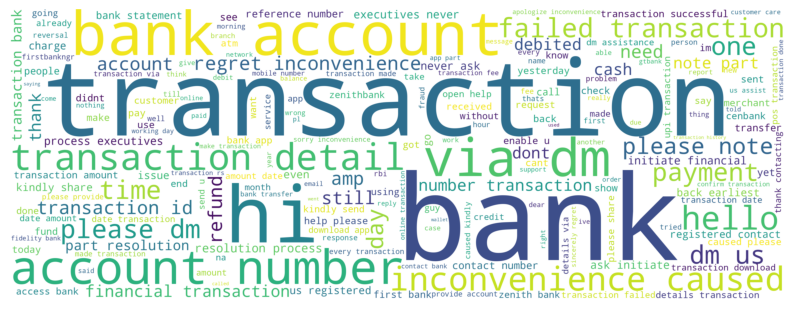

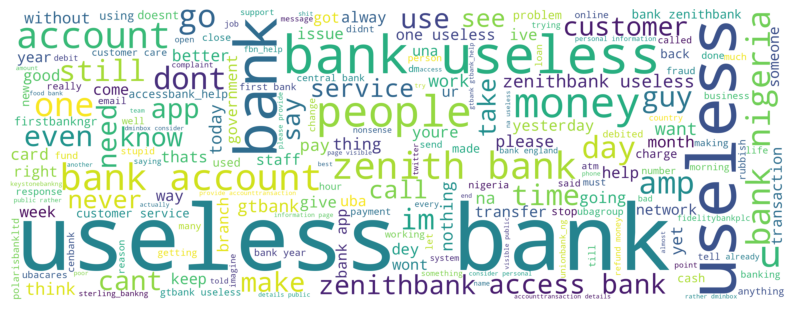

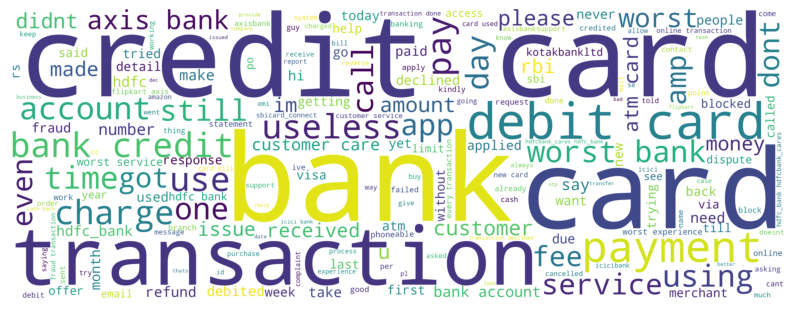

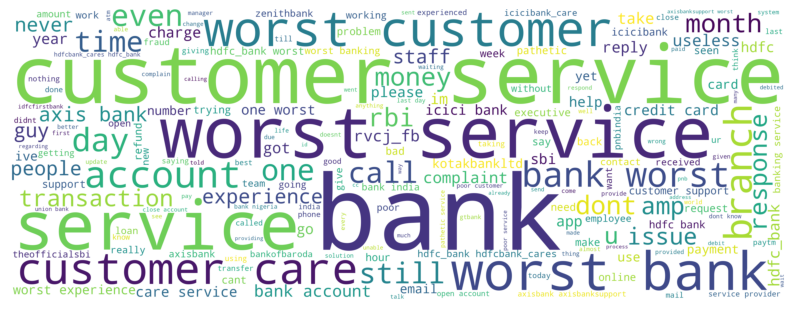

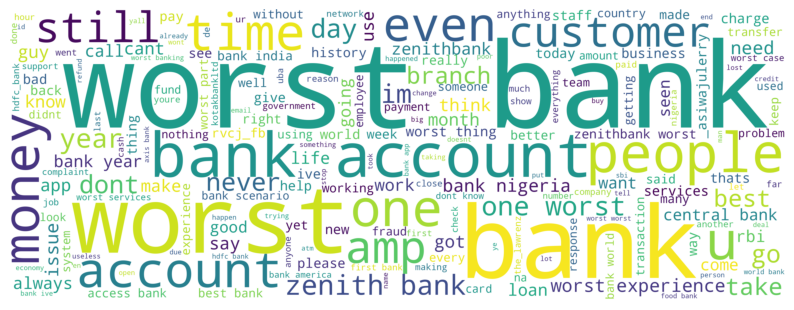

In [93]:
# apply function
identify_topics(tweet_data, desc_matrix, 7)

the 7 clusters has repeated groups of topics next I'll try a smaller number since the topics are not that stratified.

**Model topic with 4 clusters**

2    9383
3    8507
1    8318
0     920
Name: Cluster, dtype: int64


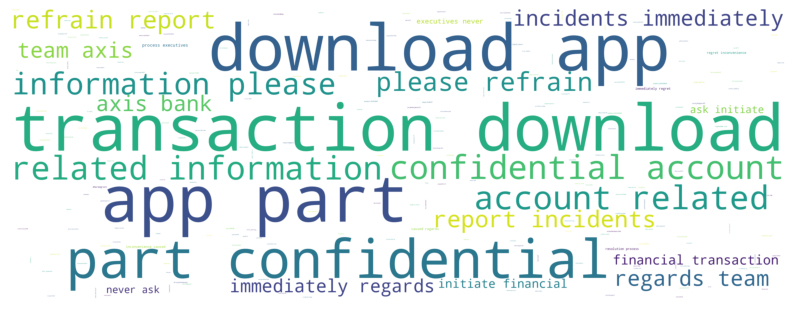

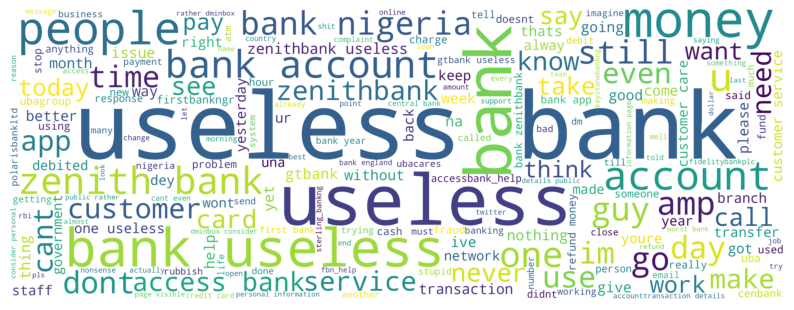

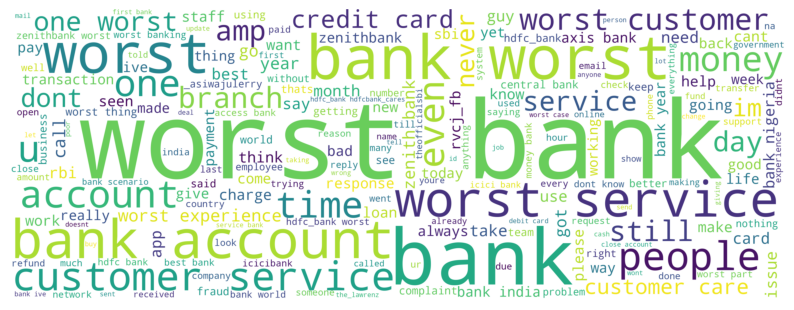

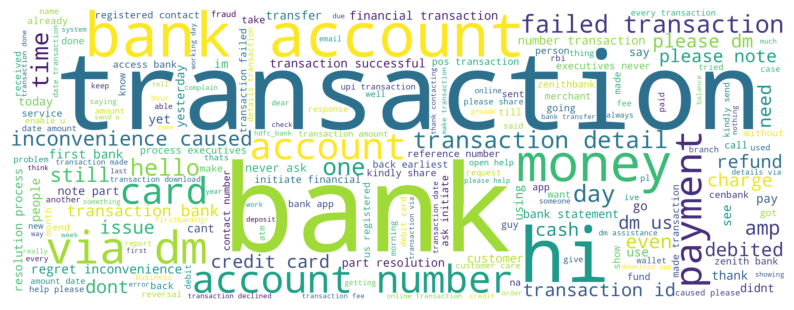

In [94]:
# apply function
identify_topics(tweet_data, desc_matrix, 4)

I'll Choose 4 as the ideal number of clusters .It can be seen from the visualization that is stratifies the tweets into 4 distinct topics Relating to banks in nigeria which are :
* **TRANSACTIONS**
* **WORST BANKS**
* **USELESS BANKS**
* **MOBILE APP**


In [96]:
#frame.to_csv('clustered_tweets.csv')